In [9]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import lfilter
f = h5py.File('lms_fun_v3.hdf5', 'r') ## Group - dictionary

In [ ]:
list(f.keys())

In [10]:
"""
Defining the LMS parameters as follows - 
    L: no. of filter taps
    Learning_rate: for updating the weights
    N: Total no. of Input Sequences
    n: no. of data samples in each input sequence    
"""
L = 3 # numbe of filter taps in Weiner filter
N = 600 # sequence length
n = 501 # number of samples in each sequence
learning_rate = [0.05, 0.1, 0.12,0.15, 0.175,0.2]
#learning_rate = [0.05, 0.15]

In [11]:
## for snr = 3dB
SNR = [3,10]
matched_v = np.zeros([len(SNR),N,n,L]) # regressor
matched_x = np.zeros([len(SNR),N,n]) # inputs
matched_y = np.zeros([len(SNR),N,n]) # ground truth outputs
matched_z = np.zeros([len(SNR),N,n]) # noisy target

matched_v[0,:,:,:] =  f['matched_3_v']
matched_v[1,:,:,:] =  f['matched_10_v']

matched_y[0,:,:] = f['matched_3_y']
matched_y[1,:,:] = f['matched_10_y']

matched_x[0,:,:] = f['matched_3_x']
matched_x[1,:,:] = f['matched_10_x']

matched_z[0,:,:] = f['matched_3_z']
matched_z[1,:,:] = f['matched_10_z']

In [12]:
"""
    Creating an LMS class as follows -
    The adapt_filter function calculates three terms - 
        1. filter output 'y'.
        2. Weights - (600, 501, 3) sized 3D array having the coefficients.
        3. w - (3,) sized 1D array calculating coefficients for each data sample in each input sequence.
        4. e - error between the original labeled output and the predicted output from the filter.
        
    The function 'adapt_filter' returns "y, e, Weights" as outputs.
    
    Additionally I have considered an error tolerance - 'epsilon' to avoid division by zero while normalization.

"""

class LMS():
    def __init__(self, L=L, learning_rate=learning_rate):
        self.L = L # no. of filter taps
        self.learning_rate = learning_rate # Eeta
        self.w = np.zeros(self.L) # initialiing the weight vector
        self.epsilon = 1e-4 # error tolerance
    
    """
    BUILDING THE WEINER FILTER 
    """
    
    def adapt_filter(self, v, x, zn, yn, N, n, normalize):
        Weights = np.zeros([N,n,3]) # N = 600, n = 501
        Y = np.zeros([N,n])
        E = np.zeros([N,n])
        for i in range(N): # for each input sequence
            self.w = np.zeros(self.L)
            for j in range(n): # for each data sample in one input sequence
                prod = np.inner(self.w, v[i,j,:]) # prediction 
                if normalize:
                    self.w += self.learning_rate*(zn[i,j]-prod)*v[i,j]/(np.inner(v[i,j],v[i,j]) + self.epsilon)
                else:
                    self.w += self.learning_rate*(zn[i,j]-prod)*v[i,j]  # each data point
                Weights[i,j,:] = self.w
                #print(Weights)
                
                y = np.inner(self.w, v[i,j]) # filter output with noise w^{T}x # scalar
                
                e = (yn[i,j] - y)**2 # error in the prediction # scalar
            
                Y[i,j] = y
                E[i,j] = e
        
        return E, Y, Weights    

In [13]:
# creating an LMS class instance - 
def Compute_LMS(v, x, z, y, snr):
    
    #fig1,axs = plt.subplots(2,2, figsize = (10,8),sharex=True, sharey=False)
    fig2,axes = plt.subplots(1,6, figsize = (21,4), sharex = True, sharey = False)
    for i in range(len(learning_rate)):
        mse = np.zeros([n])
        lr = learning_rate[i]
        lms = LMS(L=3, learning_rate=lr)


        square_error, predicted_output, weights = lms.adapt_filter(v, x, z, y, N=N, n=n, normalize=False)
        #print(square_error)
        for m in range(n): # n= 501 (600,501)
            mse[m] = np.mean(square_error[:,m], axis=0) # (501,)
        
        ## coefficient averages
        weights_average = np.zeros([n,3])
        for k in range(n):
            for j in range(L):
                weights_average[k,j] = np.sum(weights[:,k,j])/N

        original_weights = [1, 0.5, 0.25]
        labels = ["h0", "h1", "h2"]
        colors = ["c","orange","y","hotpink","m","#4CAF50"]
        #fig1.suptitle(f'Coefficients for 1st input sequence (top) & Coefficient averages over all sequences (bottom)')
    
        """
        for j in range(L):
            axs[0,i].axhline(y=original_weights[j], color='black', linestyle='--')
            axs[0,i].plot(weights[0,:,j], color=colors[j], label=labels[j])
            axs[0,i].legend(loc="lower right")
            axs[0,i].set_xlabel('Updates')
            axs[0,i].set_ylabel('Coefficients')
            axs[0,i].set_title(f'$\eta$={lr}, SNR={snr}')
            axs[1,i].plot(original_weights[j], color=colors[j])
            axs[1,i].plot(weights_average[:,j], color=colors[j], label=labels[j])
            axs[1,i].legend(loc="lower right")
            axs[1,i].set_xlabel('Updates')
            axs[1,i].set_ylabel('Coefficients')
            axs[1,i].set_title(f'$\eta$={lr}, SNR={snr}')
        """
        axes[i].plot(mse[:], color=colors[i])
        axes[i].set_title(f'$\eta$={lr}, SNR={snr}')
        axes[i].set_xlabel('Updates')
        #axes[i].set_ylabel('MSE')
        #axes[i].set_ylim([-0.1, 1])
        fig2.suptitle(f'Divergence of the MSE')
        #plt.savefig('Result_figures/Problem1(a-ii)_'+str(SNR[i])+'dB.png')
        
print("LMS successfully adapted!")
print("Weights, error and Output signal successfully predicted!")            
    

LMS successfully adapted!
Weights, error and Output signal successfully predicted!


In [ ]:
"""
    CAOMPUTATIONS AND PLOTS FOR THE 'MATCHED' FILTER
"""

for i in range(len(SNR)):
    Compute_LMS(matched_v[i,:,:,:], matched_x[i,:,:], matched_z[i,:,:], matched_y[i,:,:], snr=SNR[i])
    #plt.savefig('Result_figures/Problem1(a-iii)_'+str(SNR[i])+'dB.png')


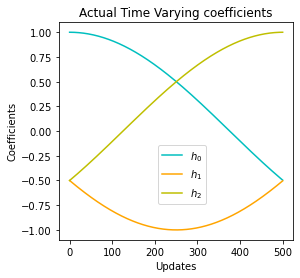

In [65]:
## ----------- Time Varying coefficients --------- ##

time_varying_coeff = f['timevarying_coefficents']
time_varying_v = np.reshape(f['timevarying_v'],(1,501,3))
time_varying_x = np.reshape(f['timevarying_x'],(1,501))
time_varying_y = np.reshape(f['timevarying_y'],(1,501))
time_varying_z = np.reshape(f['timevarying_z'],(1,501))
time_varying_coeff.shape # (1,501,3) --- 1 input sequence with 501 samples has 3 coeff changing with time.

#Compute_LMS(time_varying_v, time_varying_x, time_varying_z, time_varying_y, snr=SNR[i])

plt.figure(figsize=(4.2,4))
colors = ["c","orange","y","hotpink","m","#4CAF50"]
labels = ["$h_{0}$", "$h_{1}$", "$h_{2}$"]
for i in range(3):
    plt.plot(time_varying_coeff[:,i], color=colors[i], label=labels[i])
plt.legend(bbox_to_anchor=(0.65, 0.3),loc='center right')
plt.title(f'Actual Time Varying coefficients')
plt.xlabel('Updates')
plt.ylabel('Coefficients')
plt.savefig('Result_figures/Problem1(b)3.png')
plt.show()

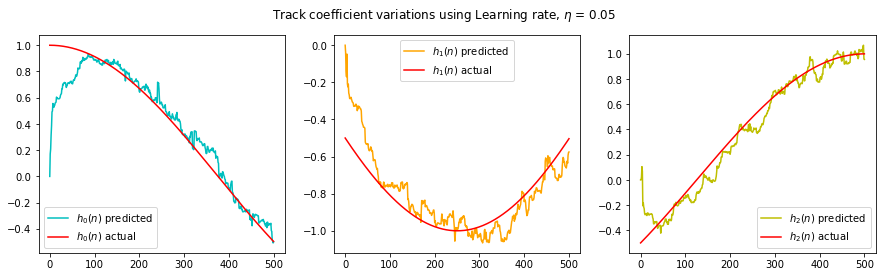

In [71]:
fig1,axs = plt.subplots(1,3,figsize=(15,4),sharex = True, sharey = False)
#fig2,axes = plt.subplots(1,6, figsize = (21,4), sharex = True, sharey = False)
learning_rate =[0.05]
fig1.suptitle(f'Track coefficient variations using Learning rate, $\eta$ = '+str(learning_rate[0]))
for i in range(len(learning_rate)):
    lr = learning_rate[i]
    lms = LMS(L=3, learning_rate=lr)
    square_error, predicted_output, weights = lms.adapt_filter(time_varying_v, time_varying_x, time_varying_z,
                                                               time_varying_y, N=1, n=n, normalize=False)
    
    labels = ['$h_{0}(n)$', '$h_{1}(n)$', '$h_{2}(n)$']
    
    labels_actual = ['$h_{0}(n)$ actual', '$h_{1}(n)$ actual', '$h_{2}(n)$ actual']
    labels_predicted = ['$h_{0}(n)$ predicted', '$h_{1}(n)$ predicted', '$h_{2}(n)$ predicted']
    axs[0].plot(weights[0,:,0], color='c', label=labels_predicted[0])
    axs[0].plot(time_varying_coeff[:,0], color='r', label=labels_actual[0])
    axs[0].legend(loc='lower left')
    #axs[0].set_xlabel()
    
    axs[1].plot(weights[0,:,1], color='orange', label=labels_predicted[1])
    axs[1].plot(time_varying_coeff[:,1], color='r', label=labels_actual[1])
    axs[1].legend(loc='upper center')
    
    axs[2].plot(weights[0,:,2], color='y', label=labels_predicted[2])
    axs[2].plot(time_varying_coeff[:,2], color='r', label=labels_actual[2])
    axs[2].legend(loc='lower right')
    
    """
    for j in range(L):
        axes[i].plot(weights[0,:,j], color=colors[j], label=labels[j])
        axes[i].set_title('$\eta$ = '+str(lr))
        axes[i].set_xlabel('updates')
    """
#fig2.suptitle(f'Effect of changing Learning rates on coefficient-variations')   
#axes[i].legend(bbox_to_anchor=(1.3, 0.2), loc='lower center')    
plt.savefig('Result_figures/Problem1(b)1.png')

Text(0.5, 0.98, 'MSE (average learning curves) for mismatched dataset for different Learning rates')

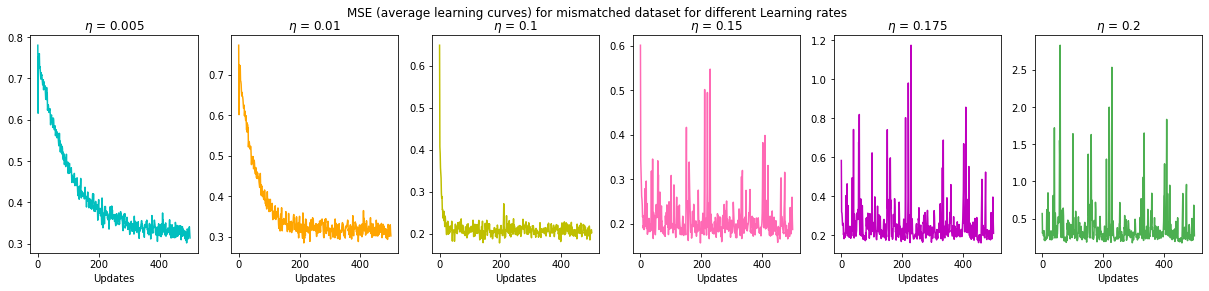

In [73]:
# ------- Mismatched Case ------- #

mismatched_v = f['mismatched_v']
mismatched_x = f['mismatched_x']
mismatched_y = f['mismatched_y']

MSE = np.zeros([6,n]) # recording MSE for each learning rate

#fig1,axs = plt.subplots(1,3,figsize=(15,4),sharex = True, sharey = False)
fig2,axes = plt.subplots(1,6, figsize = (21,4), sharex = True, sharey = False)
learning_rate =[0.005, 0.01, 0.1, 0.15, 0.175, 0.2]
#fig1.suptitle(f'Track coefficient variations using Learning rate, $\eta$ = '+str(learning_rate[0]))
for i in range(len(learning_rate)):
    mse = np.zeros([n])
    lr = learning_rate[i]
    lms = LMS(L=3, learning_rate=lr)
    square_error, predicted_output, weights = lms.adapt_filter(mismatched_v, mismatched_x, mismatched_y,
                                                               mismatched_y, N=N, n=n, normalize=False)
    
    for m in range(n):
        mse[m] = np.mean(square_error[:,m], axis=0)
        
    MSE[i,:] = mse
            
    colors = ["c","orange","y","hotpink","m","#4CAF50"]        
    labels = ['$h_{0}(n)$', '$h_{1}(n)$', '$h_{2}(n)$']
    
    #for j in range(L):
    axes[i].plot(mse[:], color=colors[i], label=labels[j])
    axes[i].set_title('$\eta$ = '+str(lr))
    axes[i].set_xlabel('Updates')
fig2.suptitle(f'MSE (average learning curves) for mismatched dataset for different Learning rates')   
#axes[i].legend(bbox_to_anchor=(1.3, 0.2), loc='lower center')    
#plt.savefig('Result_figures/Problem1(c)1.png')

In [74]:
LLSE = np.zeros([N,n])
#llse = np.zeros(n)
RV = np.zeros([N,3,3])
Rvy = np.zeros([N,3,1])
W = np.zeros([N,3,1])

for i in range(N):
    # ------ calculating R_v ----- #
    prod1 = np.matmul(np.transpose(mismatched_v[i,:,:]),mismatched_v[i,:,:])/n
    R_v = prod1
    RV[i,:,:] = R_v
    
    # ------ calculating r_vy ----- #
    prod2 = np.matmul(np.transpose(mismatched_v[i,:,:]),mismatched_y[i,:])
    r_vy = prod2/n
    Rvy[i,:,:] = r_vy.reshape((3,1))
    
    weight = np.matmul(np.linalg.inv(R_v),r_vy)
    W[i,:,:] = weight.reshape((3,1))
    
    y = np.matmul(mismatched_v[i,:,:], weight)
    
    llse =  (mismatched_y[i,:] - y)**2 
    llse.shape
    LLSE[i,:] = llse # each for each sequence
    
    #print(weight)


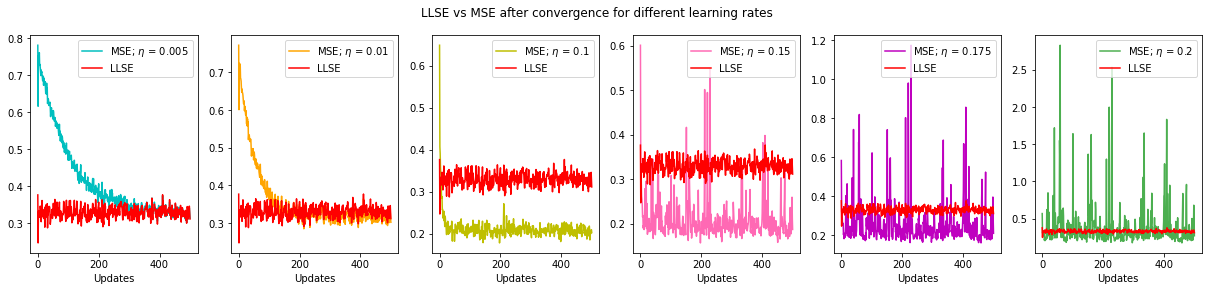

In [75]:
LLSE_average = np.mean(LLSE, axis=0) # over all sequences
learning_rate =[0.005, 0.01, 0.1, 0.15, 0.175, 0.2]
fig3, axes1 = plt.subplots(1,6, figsize = (21,4), sharex = True, sharey = False)
for i in range(len(learning_rate)):
    lr = learning_rate[i]
    label1 = 'MSE; $\eta$ = '+str(lr)
    axes1[i].plot(MSE[i,:], color=colors[i], label=label1)
    #axes1[i].set_title('$\eta$ = '+str(lr))
    axes1[i].set_xlabel('Updates')
    axes1[i].plot(LLSE_average, color='red', label='LLSE')
    axes1[i].legend()
fig3.suptitle(f'LLSE vs MSE after convergence for different learning rates')
plt.savefig('Result_figures/Problem1(c)2.png')

In [ ]:
## copyright, Keith Chugg
##  EE599, 2020

#################################################
## this is a template to illustrate hd5 files
##
## also can be used as template for HW1 problem
##################################################

import h5py
import numpy as np
import matplotlib.pyplot as plt 

DEBUG = False
DATA_FNAME = 'Aditi_Bodhankar_EE541_Hw2Prob2.hd5'

if DEBUG:
    num_sequences = 3
    sequence_length = 4
else:
    num_sequences = 25
    sequence_length = 20

### Enter your data here...
# ----------------------- MY CODE ----------------------- #
"""
    Here I create a random binary sequence generator using numpy as follows - 
"""
my_list = [
    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
    [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0],
    [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
    [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
    [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1],
    [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0],
    [1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
    [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
    [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1],
    [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
    [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1],
    [0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0],
    [1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
    [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1],
]

# -----------------------   END   ----------------------- #
### Be sure to generate the data by hand.  DO NOT:
###     copy-n-paste
###     use a random number generator 
###
x_list = [
    [ 0, 1, 1, 0],
    [ 1, 1, 0, 0],
    [ 0, 0, 0, 1]
]

# convert list to a numpy array...
human_binary = np.asarray(my_list)

### do some error trapping:

assert human_binary.shape[0] == num_sequences, 'Error: the number of sequences was entered incorrectly'
assert human_binary.shape[1] == sequence_length, 'Error: the length of the seqeunces is incorrect'

# the with statement opens the file, does the business, and close it up for us...
with h5py.File(DATA_FNAME, 'w') as hf:
    hf.create_dataset('human_binary', data = human_binary)
    ## note you can write several data arrays into one hd5 file, just give each a different name.

###################
# Let's read it back from the file and then check to make sure it is as we wrote...
with h5py.File(DATA_FNAME, 'r') as hf:
    hb_copy = hf['human_binary'][:]

### this will throw and error if they are not the same...
np.testing.assert_array_equal(human_binary, hb_copy)

In [ ]:
print(hb_copy == human_binary)

In [ ]:
def generate_random_binary_sequence(r,c):
    A = np.zeros([r,c])
    for i in range(r):
        for j in range(c):
            k = np.random.randint(0,2)
            A[i,j] = k
    return A

In [ ]:
my_list.shape

In [ ]:
Problem

In [ ]:
list(Problem2.keys())

In [ ]:
N = 100; seed=42
a = -1; b = 1

randnum = (int(a+(b-a)*(abs(hash(str(hash(str(seed)+str(i+1))))) % 10**13)/ 10**13) for i in range(N))

In [ ]:
25*20

In [ ]:

for i in range(20):
    num = input('Enter '+str(i+1)+'th number: ')
    
    

A

In [ ]:
my_list = [
    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
    [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0],
    [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
    [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
    [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1],
    [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0],
    [1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
    [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
    [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1],
    [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
    [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1],
    [0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0],
    [1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
    [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1],
]

